# Neural Networks for solving regression problem: Manual Hyperparameter tuning
Author: Jishnu Prakash Kunnanath Poduvattil

This notebook is to learn the influence of each hyperparameter in a deep learning model, And thus finding the best hyperparameter values.

Methodology:-

A default model of simple architecture is defined as base model. For each hyperparamter, values is varied and the model is trained for each value. The training and validation loss is monitored to analyse the performance. Then each model is tested and the error is plotted for selecting the best model. 

## 1. Importing Libraries
Tensorflow and Keras is used to build deep neural networks for solving the regression problem. Scikit-learn is used for data pre-processing, train-test split and evaluating the performance of the model. Matplotlib is used for plotting the graphs.

In [1]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## 2. Data Pre-processing

Loading data using pandas and using standard scaling on the data.

In [2]:
#Load dataset
data = pd.read_csv("clean_kcHouse.csv")
data.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_living15', 'sqft_lot15', 'age', 'reno_age',
       'reno_flag'],
      dtype='object')

A detailed exploratory data analysis was performed on the data. Please refer EDA_kcHouse notebook to learn more about the insights on data and feature selection.

Here, the Target variable **Price** is an economic variable. To represent Vertical changes in prices related to various attributes, Logarithmic scale is used. Reference: https://www.visualizingeconomics.com/blog/2016/8/5/real-growth-in-us-housing-prices-log-scale 

So converting the price to log scale.

The model predictions can be converted to normal range by taking the exponential of predicted values.

Train-Test split is 80-20.

In [3]:
X = data.drop("price", axis=1) #Selecting features
y = data["price"].apply(np.log) #Selecting and transforming Target

# Feature Scaling
sc = StandardScaler() #Initilaising standard scaler 
X = sc.fit_transform(X) #Transforming data to standard format (0 to 1)

# Splitting the dataset into the Training set and Test set
randomState = 32 #setting random state to a constant for obtaining same results every time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=randomState)

## 3. Defining Functions and Base model
A base model is defined with a simple architecture. Please find the specific values in the function baseModel below. 

Earlystopping is used to avoid overfitting in model.

Please refer to function documentation to understand the working.

In [4]:
def baseModel(value={}):
    """
    Python dictionary of default values for building base model
    value: Input values to change baseModel
    """
    config = {
            "h_nodes" : [32],
            "activation" : 'relu',
            "out_nodes" : 1,
            "optimizer" : "rmsprop",
            "lr" : 0.01,
            "epochs" : 30,
            "batch" : 16,
            "val_split" : 0.2,
            "verbose" : 1,
            "loss" : "mse"
            }
    #Change default values if input is present
    if len(value)>0:
        for i in value.keys():
            config[i] = value[i]
    return config

def getOptimizer(name, lr):
    """
    Map and initialise optimizers with learning rate:-
    'adagrad', 'rmsprop', 'adam', 'sgd', 'nadam'
    
    """
    optimizer=None
    if name == 'adagrad': 
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=lr)
    elif 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    elif'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)   
    elif 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    elif 'nadam':
        optimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
    return optimizer

def getLossFunction(name):
    """
    Map and initialise loss functions
    mse = Mean squared error
    mae = Mean absolute error
    mape = Mean absolute pecentage error
    msle = Mean squared logarithmic error
    cos = cosine similarity
    huber = huber loss
    """
    if name == "mse":
        loss = tf.keras.losses.MeanSquaredError()
    elif "mae":
        loss = tf.keras.losses.MeanAbsoluteError()
    elif "mape":
        loss = tf.keras.losses.MeanAbsolutePercentageError()
    elif "msle":
        loss = tf.keras.losses.MeanSquaredLogarithmicError()
    elif "cos":
        loss = tf.keras.losses.CosineSimilarity(axis=1)
    elif "huber":
        loss = tf.keras.losses.Huber()
    return loss
        

def initRunModel(config, X_train, y_train, model, batchNormalise=True, dropOut=False, summary=True):
    """
    Initialise and Run model training
    config = model configuration
    X_train = train data
    y_train = train labels
    model = Name of model
    summary = True or False to print model summary
    """
    #Clear memory
    tf.keras.backend.clear_session()
    tf.random.set_seed(randomState)
    np.random.seed(randomState)
    #Initialise model
    model=tf.keras.models.Sequential(name=model)
    #Input layer
    model.add(
        tf.keras.layers.Input(name = "Input",
        shape = (X_train.shape[1],))
        )

    #Add Hidden Layers
    for layer in range(len(config["h_nodes"])):
        layer_name = "Dense_layer_" + str(layer)
        model.add(
            tf.keras.layers.Dense(units = config["h_nodes"][layer],
            name = layer_name,
            activation = config["activation"],
            kernel_regularizer="l2")
            )
            
        #Batch Normalization
        if batchNormalise:
            model.add(tf.keras.layers.BatchNormalization())
        
    if dropOut:
        model.add(tf.keras.layers.Dropout(0.2))
        
    #Output layer
    model.add(
        tf.keras.layers.Dense(units = config["out_nodes"],
        name = "Output",
        activation = config["activation"])
        )
    #Compile model
    model.compile(
        loss = getLossFunction(config["loss"]),
        optimizer = getOptimizer(config["optimizer"], config["lr"]),
        metrics = [tf.keras.metrics.RootMeanSquaredError()]
        )
    #Print summary   
    if summary:
        print("\n\n")
        model.summary()

    #Train model
    history = model.fit(
        X_train, y_train,
        batch_size = config["batch"],
        epochs = config["epochs"],
        verbose = config["verbose"],
        validation_split = config["val_split"],
        callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8) #Early stopping to avoid overfitting
        )
    
    return history, model


def plotModelPerformance(history, title="Model Training Performance"):
    """
    Plot model performance
    """
    plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
    plt.plot(history.history['val_root_mean_squared_error'], label='val_root_mean_squared_error')
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plotPerformance(trainHistory, title, rows):
    """
    Creates and plot subplots of model training values
    """
    fig, axes = plt.subplots(nrows=rows, ncols=1, figsize=(10, 20))
    fig.text(0.5, 0.04, 'Epochs', ha='center')
    fig.text(0.04, 0.5, 'Root Mean Squared Error', va='center', rotation='vertical')
    for i, j in enumerate(trainHistory):
        axes[i].plot(trainHistory[j].history['root_mean_squared_error'], label='root_mean_squared_error')
        axes[i].plot(trainHistory[j].history['val_root_mean_squared_error'], label='val_root_mean_squared_error')
        axes[i].set_title(title + str(j))
    lines_labels = [axes.get_legend_handles_labels() for axes in fig.axes]
    lines, labels = [sum(lol, [])[0:2] for lol in zip(*lines_labels)]
    fig.legend(lines, labels)
    plt.show()

def plotTestR2(test_measures, xlabels, title, log=False):
    """
    Plot test performance values
    """
    plt.title(title)
    index = list(range(len(test_measures)))
    if log:
        plt.xscale("log")
        plt.plot(xlabels, test_measures,color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
    else:
        plt.xticks(index, xlabels)
        plt.plot(index, test_measures,color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
    plt.show()

def plotComparison(measures, title):
    """
    Plot multiple validation losses 
    """
    plt.figure(figsize=(15, 8))
    for experiment in measures.keys():
        x = measures[experiment].history['val_root_mean_squared_error']
        plt.plot(x, label=experiment, linewidth=3)

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Validation RMSE")
    plt.legend()
    plt.show()

# 4. Hyperparameter Tuning 

## 4.1 Number of Hidden Layers
Here, we train the base model with different hidden layers from 1 to 6. We would like to know what happens to model when trained with different hidden layers.

In [83]:
layer_measures = {}
layer_test = []
for i in range(1,6):
    base_config = baseModel(value={'verbose':0}) #Inititae base model
    base_config['h_nodes'] = base_config['h_nodes'] * i #Set number of layers
    name = "HiddenLayer_"+ str(i)
    print("Training with", str(len(base_config['h_nodes']))," Hidden Layers")
    training = initRunModel(base_config, X_train=X_train, y_train=y_train, model=name, batchNormalise=False, summary=False) #Train the model
    layer_measures[i] = training[0]
    y_pred = training[1].predict(X_test) #Make predictions
    r2 = metrics.r2_score(y_test, y_pred) #Compute R sqyared value
    layer_test.append(r2)
    print("Evaluating Model, RMSE = ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #Compute Root mean squared value
    print('R square Score:', r2, '\n')

Training with 1  Hidden Layers
Evaluating Model, RMSE =  0.32070928703992063
R square Score: 0.5114167805837249 

Training with 2  Hidden Layers
Evaluating Model, RMSE =  0.31229151539550126
R square Score: 0.5367282218351759 

Training with 3  Hidden Layers
Evaluating Model, RMSE =  0.31051095508883153
R square Score: 0.5419959394819543 

Training with 4  Hidden Layers
Evaluating Model, RMSE =  0.31043530671280706
R square Score: 0.5422190752029021 

Training with 5  Hidden Layers
Evaluating Model, RMSE =  0.31150082151473
R square Score: 0.5390711765108858 



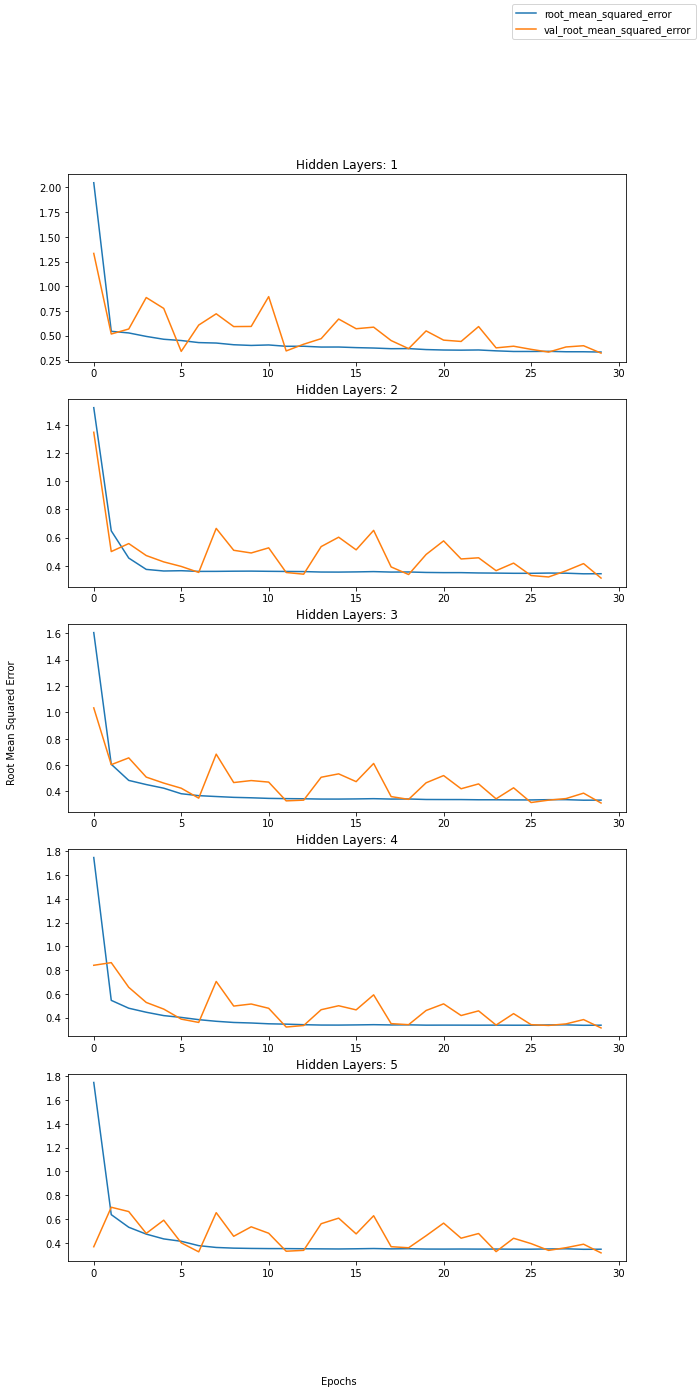

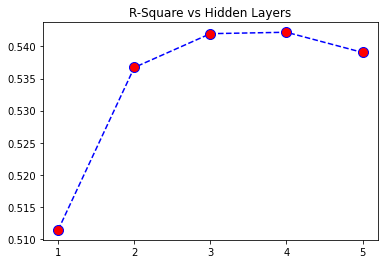

In [84]:
#Plot errors
plotPerformance(layer_measures, "Hidden Layers: ", len(layer_measures)) #plot train errors
# plotComparison(layer_measures, "Comparing Validation RMSE") #Uncomment to plot validation loss together
plotTestR2(layer_test, list(layer_measures.keys()), "R-Square vs Hidden Layers") #plot test errors

Here, 4 layers gives the best performance. But when moving forward there was no improvement in the R squared value. So reverted back and tested for the next best values and found out that 2 layers gives the best performance in next tuning stages, so selecting 2 layers. 

## 4.2 Number of nodes
Here, we train the base model with different hidden nodes from 8 to 56. We would like to know what happens to model when trained with different hidden nodes.

In [85]:
layers = 2
node_measures = {}
node_test = []
for i in range(8,64,8):
    base_config = baseModel(value={'verbose':0}) #Initiate base model
    base_config['h_nodes'] = [i]*layers
    name = "HiddenNodes_"+ str(i)
    print("Training with", str(base_config['h_nodes'])," Hidden Nodes")
    training = initRunModel(base_config, X_train=X_train, y_train=y_train, model=name, batchNormalise=False, summary=False)
    node_measures[str([i]*layers)] = training[0]
    y_pred = training[1].predict(X_test)
    r2 = metrics.r2_score(y_test, y_pred)
    node_test.append(r2)
    print("Evaluating Model, RMSE = ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R square Score:', r2, '\n')

Training with [8, 8]  Hidden Nodes
Evaluating Model, RMSE =  0.30162289604765663
R square Score: 0.5678404791923635 

Training with [16, 16]  Hidden Nodes
Evaluating Model, RMSE =  0.3034782032412192
R square Score: 0.5625076307102606 

Training with [24, 24]  Hidden Nodes
Evaluating Model, RMSE =  0.31311725300236326
R square Score: 0.5342750865212643 

Training with [32, 32]  Hidden Nodes
Evaluating Model, RMSE =  0.31229151539550126
R square Score: 0.5367282218351759 

Training with [40, 40]  Hidden Nodes
Evaluating Model, RMSE =  0.31286674173997514
R square Score: 0.5350200002166654 

Training with [48, 48]  Hidden Nodes
Evaluating Model, RMSE =  0.3137778023628858
R square Score: 0.5323080356347082 

Training with [56, 56]  Hidden Nodes
Evaluating Model, RMSE =  0.3293832610760966
R square Score: 0.48463072412479646 



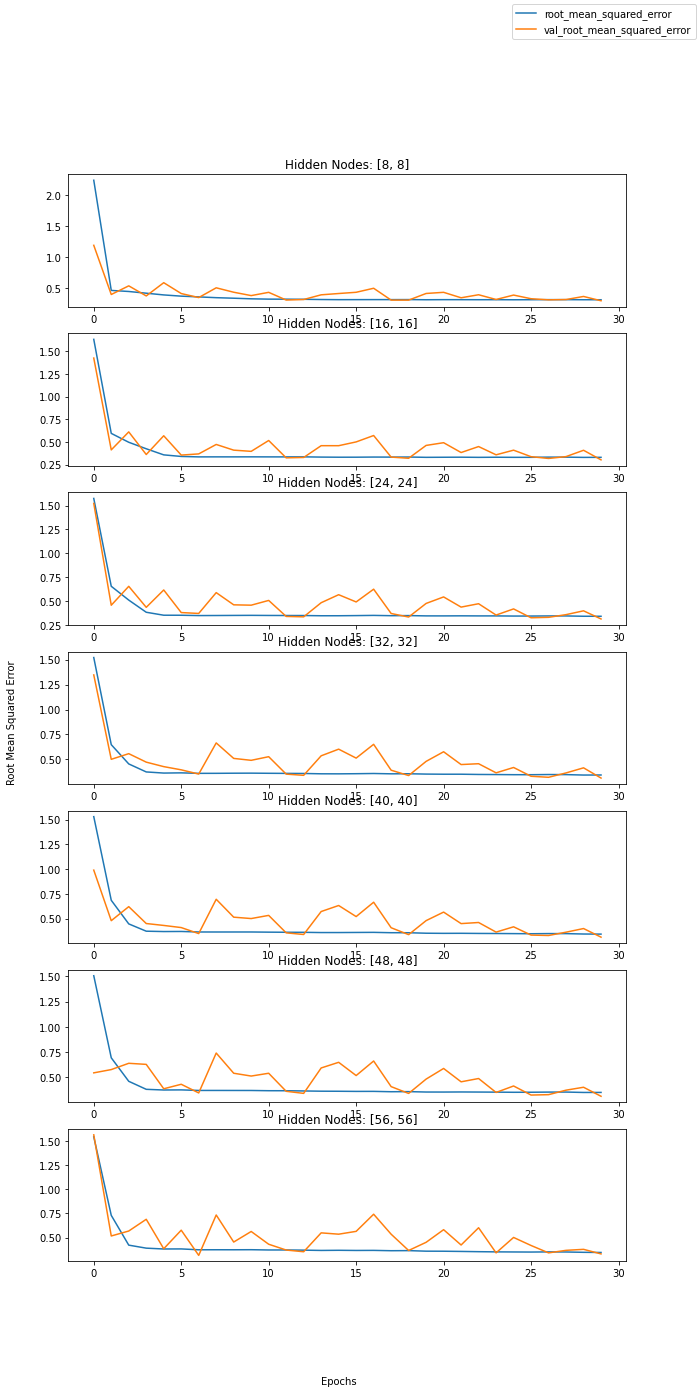

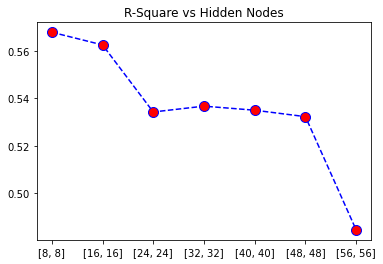

In [86]:
#Plot Graphs
plotPerformance(node_measures, "Hidden Nodes: ", len(node_measures)) #plot train errors
# plotComparison(node_measures, "Comparing Validation RMSE")
plotTestR2(node_test, list(node_measures.keys()), "R-Square vs Hidden Nodes") #plot test errors

We can observe the best results in 2 hidden layers with 8 nodes each. There is improvement in R squared value.

## 4.3 Optimizers
Here, we train the base model with different values of optimizers from ['sgd','rmsprop','adam','adagrad']. We would like to know what happens to model when trained with different optimizers.

In [87]:
optimiser_measures = {}
optimiser_test = []
for i in ['sgd','rmsprop','adam','adagrad', 'nadam']:
    base_config = baseModel(value={'verbose':0, 'h_nodes':[8, 8]})
    base_config['optimizer'] = i
    name = "optimizer_"+ str(i)
    print("Training with optimizer:", base_config['optimizer'])
    training = initRunModel(base_config, X_train=X_train, y_train=y_train, model=name, batchNormalise=False, summary=False)
    optimiser_measures[i] = training[0]
    y_pred = training[1].predict(X_test)
    r2 = metrics.r2_score(y_test, y_pred)
    optimiser_test.append(r2)
    print("Evaluating Model, RMSE = ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R square Score:', r2, '\n')

Training with optimizer: sgd
Evaluating Model, RMSE =  0.30162289604765663
R square Score: 0.5678404791923635 

Training with optimizer: rmsprop
Evaluating Model, RMSE =  0.30162289604765663
R square Score: 0.5678404791923635 

Training with optimizer: adam
Evaluating Model, RMSE =  0.30162289604765663
R square Score: 0.5678404791923635 

Training with optimizer: adagrad
Evaluating Model, RMSE =  0.7152888794776194
R square Score: -1.430403716056666 

Training with optimizer: nadam
Evaluating Model, RMSE =  0.30162289604765663
R square Score: 0.5678404791923635 



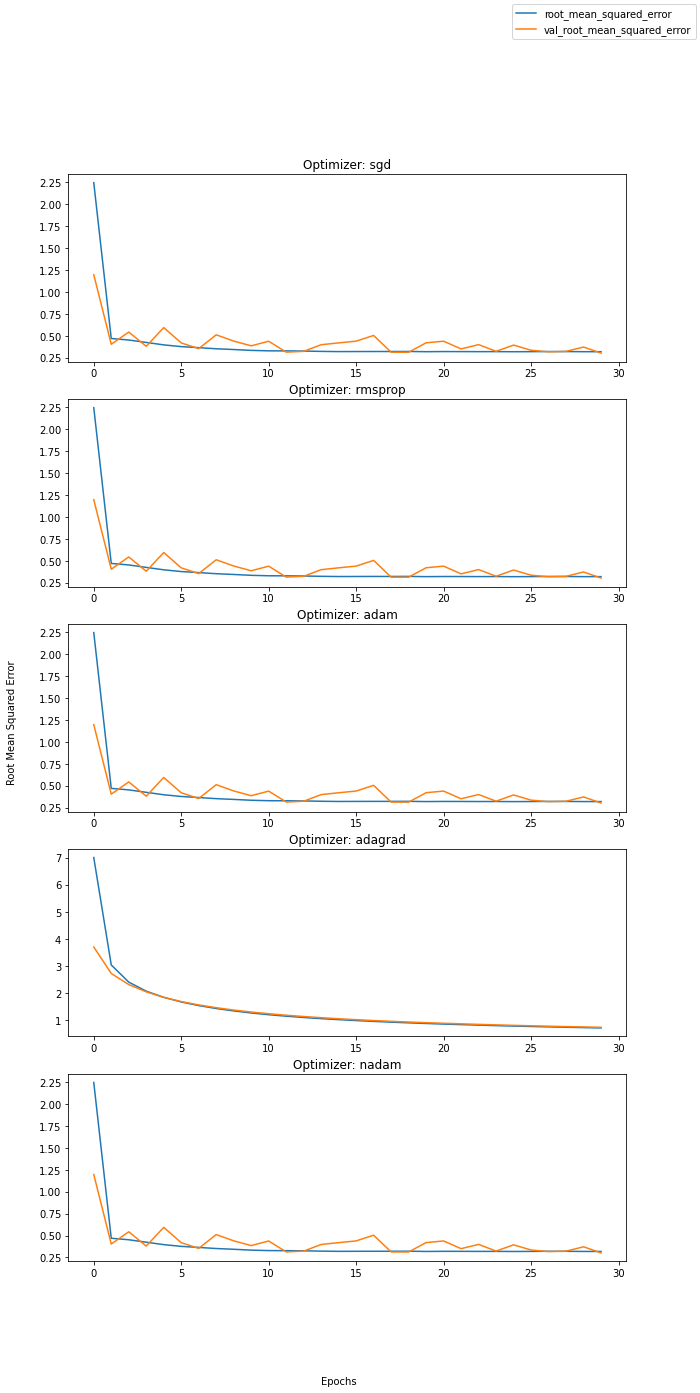

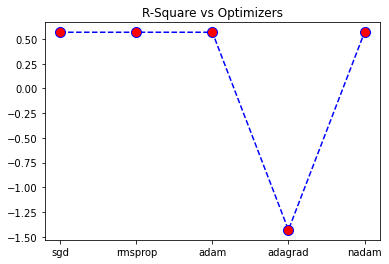

In [88]:
#Plot graphs
plotPerformance(optimiser_measures, "Optimizer: ", len(optimiser_measures)) #plot train errors
# plotComparison(optimiser_measures, "Comparing Validation RMSE")
plotTestR2(optimiser_test, list(optimiser_measures.keys()), "R-Square vs Optimizers") #plot test errors

This is an interesting observation. ADAM, SGD, NADAM and RMSPROP gives similar performance here. So proceeding with ADAM

## 4.4 Learning Rate
Here, we train the base model with different values of learning rate from 0.00001 to 1. We would like to know what happens to model when trained with different values. We took this range of test values by convention.

In [15]:
lr_test = []
lr_measures = {}
for i in [0.0001, 0.001, 0.01, 0.1, 0.5, 1]:
    base_config = baseModel(value={'verbose':0, 'h_nodes':[8, 8], 'optimizer':'adam'}) #Initialise base model
    base_config['lr'] = i
    name = "lr_"+ str(i)
    print("Training with Learning rate:", base_config['lr'])
    training = initRunModel(base_config, X_train=X_train, y_train=y_train, model=name, batchNormalise=False, summary=False) #Train the model
    lr_measures[i] = training[0]
    y_pred = training[1].predict(X_test) #Predict with test data
    r2 =  metrics.r2_score(y_test, y_pred)
    lr_test.append(r2)
    print("Evaluating Model, RMSE = ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R square Score:', r2, '\n')

Training with Learning rate: 0.0001
Evaluating Model, RMSE =  0.5252790608171031
R square Score: -0.31067692021626514 

Training with Learning rate: 0.001
Evaluating Model, RMSE =  0.2969220464736576
R square Score: 0.5812060833237882 

Training with Learning rate: 0.01
Evaluating Model, RMSE =  0.30162289604765663
R square Score: 0.5678404791923635 

Training with Learning rate: 0.1
Evaluating Model, RMSE =  0.40761379707162054
R square Score: 0.2107524803387648 

Training with Learning rate: 0.5
Evaluating Model, RMSE =  12.988635404531648
R square Score: -800.3874308471244 

Training with Learning rate: 1
Evaluating Model, RMSE =  12.988635404531648
R square Score: -800.3874308471244 



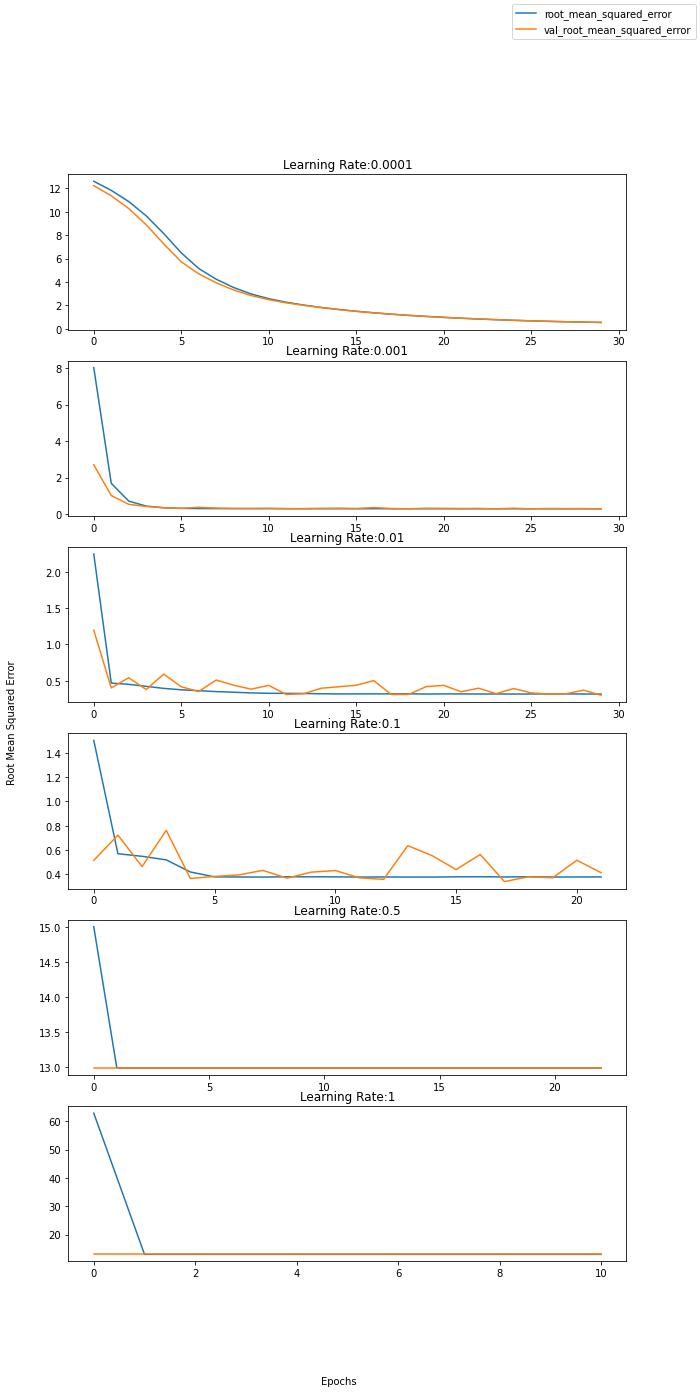

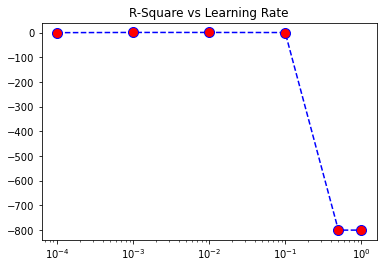

In [16]:
#Plot graphs
plotPerformance(lr_measures, "Learning Rate:", len(lr_measures)) #Plot training erros
# plotComparison(lr_measures, "Comparing Validation RMSE")
plotTestR2(lr_test, list(lr_measures.keys()), "R-Square vs Learning Rate", True) #Plot test errors

From the above plots, We can see that we get a fast and stable convergence when leanring rate is 0.001.

For smaller learning rates, convergence is slow. But for the highest leanring rates, convergence is too quick and model is overfitting, so we cannot rely on that.

So Best Learning rate is 0.001.

## 4.5 Activations
Here, we train the base model with different values of activations from ['relu', 'tanh', 'elu', 'sigmoid', 'softmax', 'selu']. We would like to know what happens to the model when trained with different activation functions.

In [90]:
act_measures = {}
act_test = []
for i in ['relu', 'tanh', 'elu', 'sigmoid', 'softmax', 'selu', 'linear']:
    base_config = baseModel(value={'verbose':0, 'lr':0.001, 'h_nodes':[8, 8], 'optimizer':'adam'})
    base_config['activation'] = i
    name = "activation_"+ str(i)
    print("Training with activation:", base_config['activation'])
    training = initRunModel(base_config, X_train=X_train, y_train=y_train, model=name, batchNormalise=False, summary=False)
    act_measures[i] = training[0]
    y_pred = training[1].predict(X_test)
    r2 = metrics.r2_score(y_test, y_pred)
    act_test.append(r2)
    print("Evaluating Model, RMSE = ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R square Score:', r2, '\n')

Training with activation: relu
Evaluating Model, RMSE =  0.2969220464736576
R square Score: 0.5812060833237882 

Training with activation: tanh
Evaluating Model, RMSE =  11.989311556863134
R square Score: -681.8164357245779 

Training with activation: elu
Evaluating Model, RMSE =  0.3035019360953102
R square Score: 0.5624392017526412 

Training with activation: sigmoid
Evaluating Model, RMSE =  11.989311556863134
R square Score: -681.8164357245779 

Training with activation: softmax
Evaluating Model, RMSE =  11.989311556863134
R square Score: -681.8164357245779 

Training with activation: selu
Evaluating Model, RMSE =  0.30250638667120694
R square Score: 0.5653050744060995 

Training with activation: linear
Evaluating Model, RMSE =  0.3072399772641568
R square Score: 0.5515945083148599 



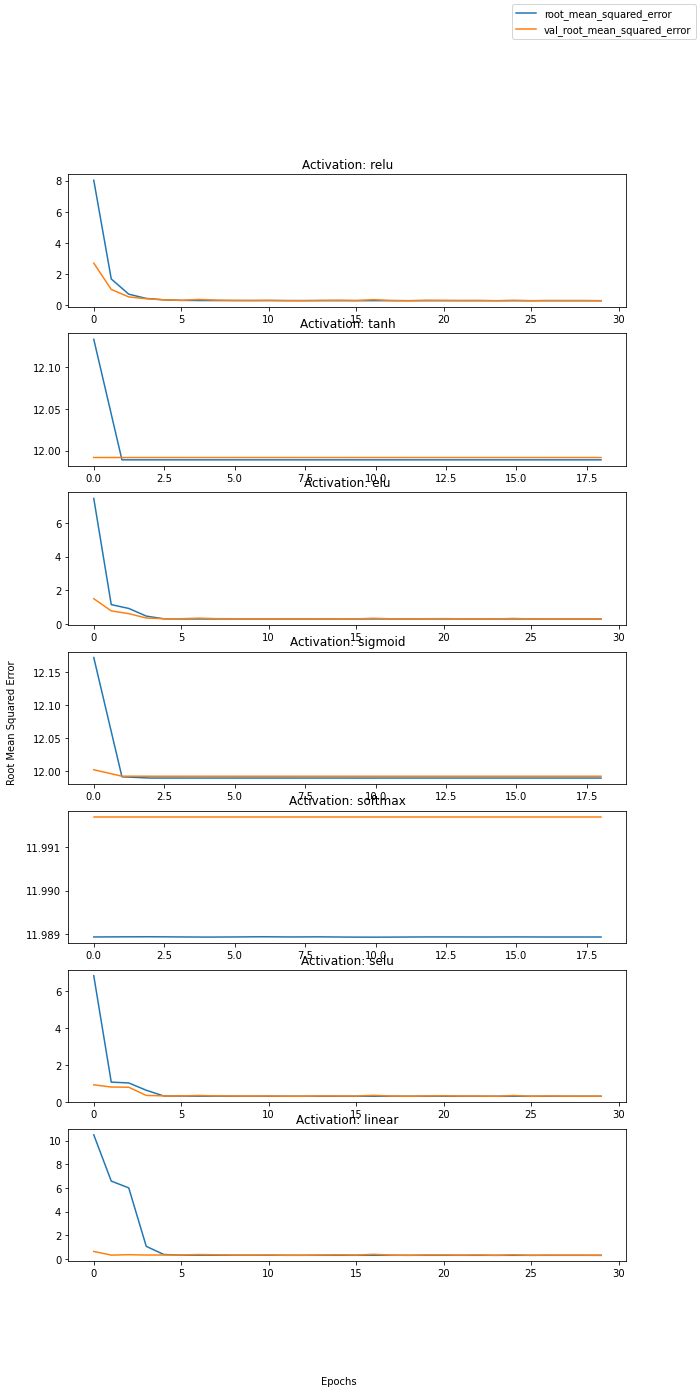

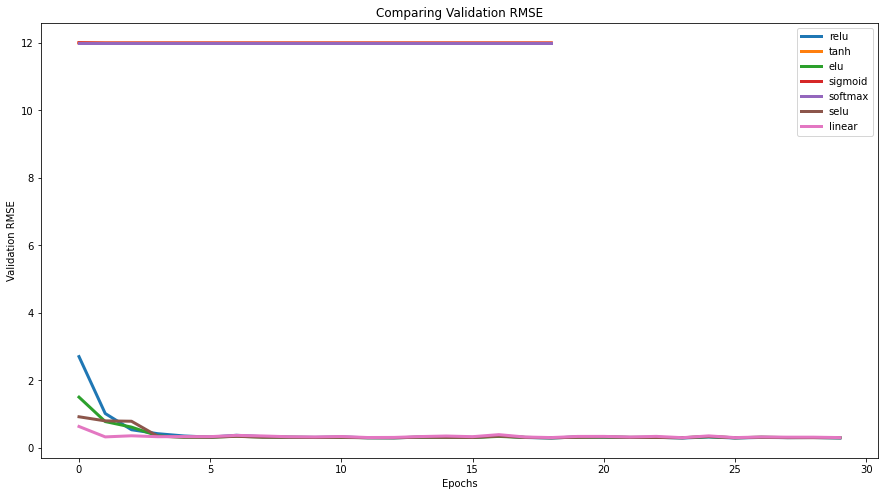

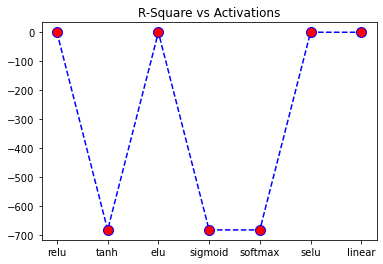

In [91]:
#Plot graphs
plotPerformance(act_measures, "Activation: ", len(act_measures)) #plot train errors
plotComparison(act_measures, "Comparing Validation RMSE")
plotTestR2(act_test, list(act_measures.keys()), "R-Square vs Activations") #plot test errors

We get the best performance for RELU activation function. We can observe that tanh, sigmoid and softmax activations are not suitable for this task and training is stopped by Early stopping.

## 4.6 Loss Function
Here, we train the base model with different values of loss functions from ['mse', 'mae', 'mape', 'msle', 'cos']. We would like to know what happens to model when trained with different loss functions.

In [57]:
loss_measures = {}
loss_test = []
for i in ['mse', 'mae', 'mape', 'msle', 'cos']:
    base_config = baseModel(value={'verbose':0, 'lr':0.001, 'h_nodes':[8, 8], 'optimizer':'adam', 'activation':'relu'})
    base_config['loss'] = i
    name = "lossFunction_"+ str(i)
    print("Training with Loss Function:", base_config['loss'])
    training = initRunModel(base_config, X_train=X_train, y_train=y_train, model=name, batchNormalise=False, summary=False)
    loss_measures[i] = training[0]
    y_pred = training[1].predict(X_test)
    r2 =  metrics.r2_score(y_test, y_pred)
    loss_test.append(r2)
    print("Evaluating Model, RMSE = ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R square Score:', r2, '\n')

Training with Loss Function: mse
Evaluating Model, RMSE =  0.2969220464736576
R square Score: 0.5812060833237882 

Training with Loss Function: mae
Evaluating Model, RMSE =  0.31794951837071345
R square Score: 0.5197893172562735 

Training with Loss Function: mape
Evaluating Model, RMSE =  0.31794951837071345
R square Score: 0.5197893172562735 

Training with Loss Function: msle
Evaluating Model, RMSE =  0.31794951837071345
R square Score: 0.5197893172562735 

Training with Loss Function: cos
Evaluating Model, RMSE =  0.31794951837071345
R square Score: 0.5197893172562735 



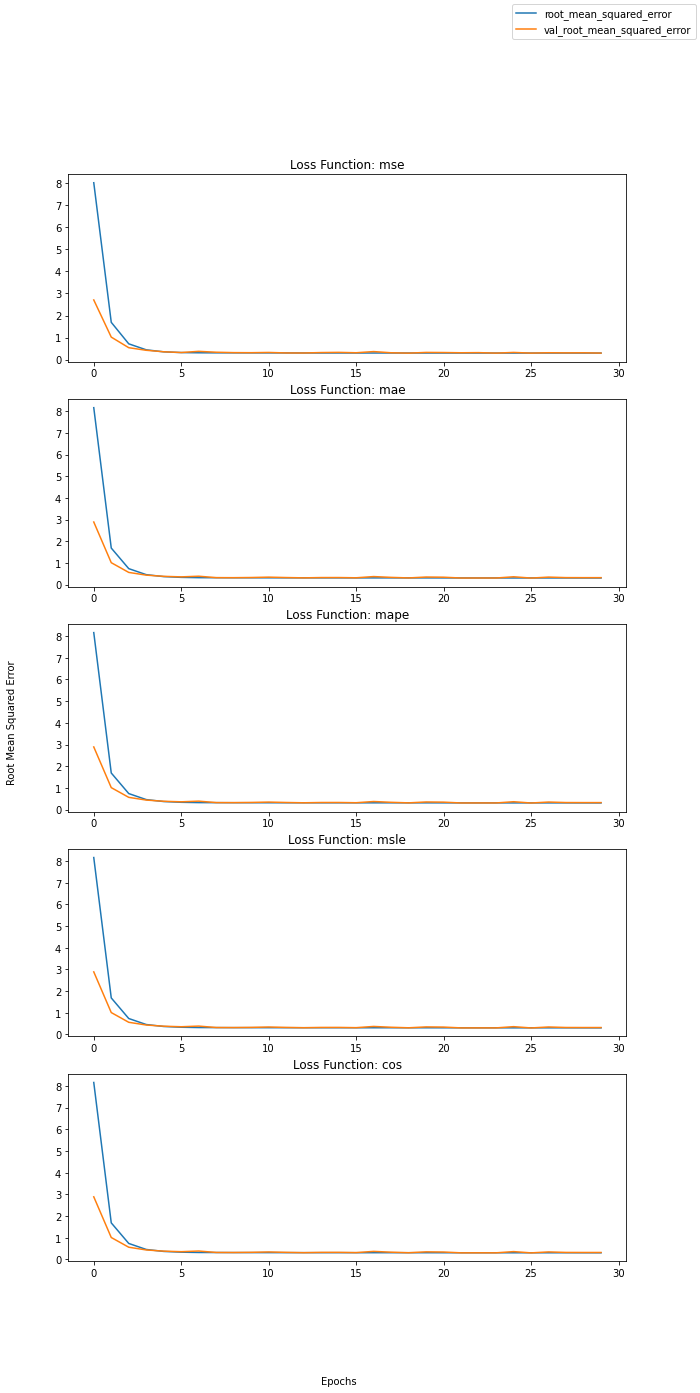

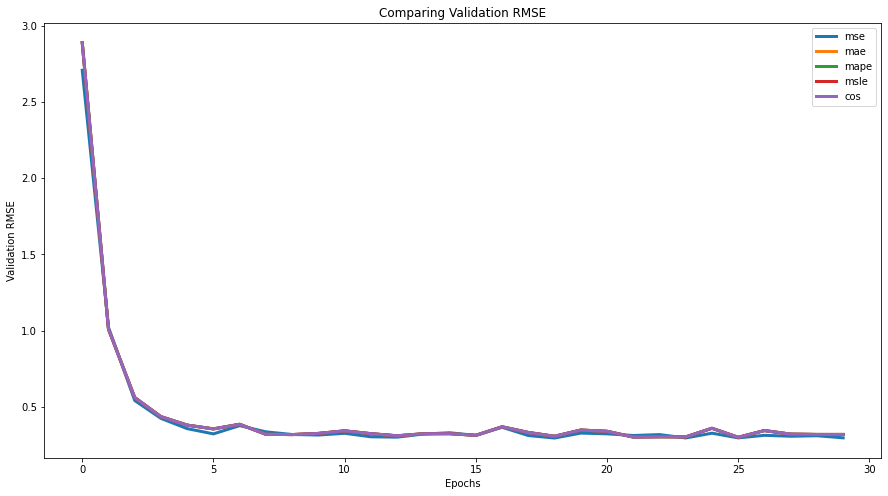

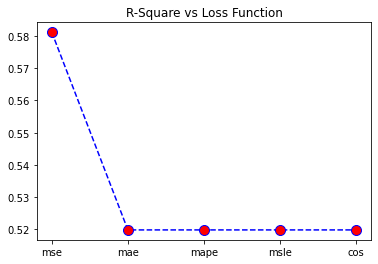

In [59]:
#Plot Graphs
plotPerformance(loss_measures, "Loss Function: ", len(loss_measures)) #plot train errors
plotComparison(loss_measures, "Comparing Validation RMSE")
plotTestR2(loss_test, list(loss_measures.keys()), "R-Square vs Loss Function") #plot test errors

Mean squared error gives better R squared value.

## 4.7 Batch size
Here, we train the base model with different values of batch size from 8 to 128. We would like to know what happens to model when trained with different batch sizes. We took this range of test values by convention. 

In [118]:
batch_measures = {}
batch_test = []
for i in [8, 16, 32, 64, 128]:
    base_config = baseModel(value={'verbose':0, 'lr':0.001, 'h_nodes':[8, 8], 'optimizer':'adam', 'activation':'relu', 'loss':'mse'})
    base_config['batch'] = i
    name = "batch_"+ str(i)
    print("Training with Batch size:", base_config['batch'])
    training = initRunModel(base_config, X_train=X_train, y_train=y_train, model=name, batchNormalise=False, summary=False)
    batch_measures[i] = training[0]
    y_pred = training[1].predict(X_test)
    r2 = metrics.r2_score(y_test, y_pred)
    batch_test.append(r2)
    print("Evaluating Model, RMSE = ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R square Score:', r2, '\n')

Training with Batch size: 8
Evaluating Model, RMSE =  0.2975264942216278
R square Score: 0.5794992602576821 

Training with Batch size: 16
Evaluating Model, RMSE =  0.2969220464736576
R square Score: 0.5812060833237882 

Training with Batch size: 32
Evaluating Model, RMSE =  0.29756648802467617
R square Score: 0.5793862044162638 

Training with Batch size: 64
Evaluating Model, RMSE =  0.3019422734726279
R square Score: 0.5669247989177114 

Training with Batch size: 128
Evaluating Model, RMSE =  0.3018391256705803
R square Score: 0.5672206377515034 



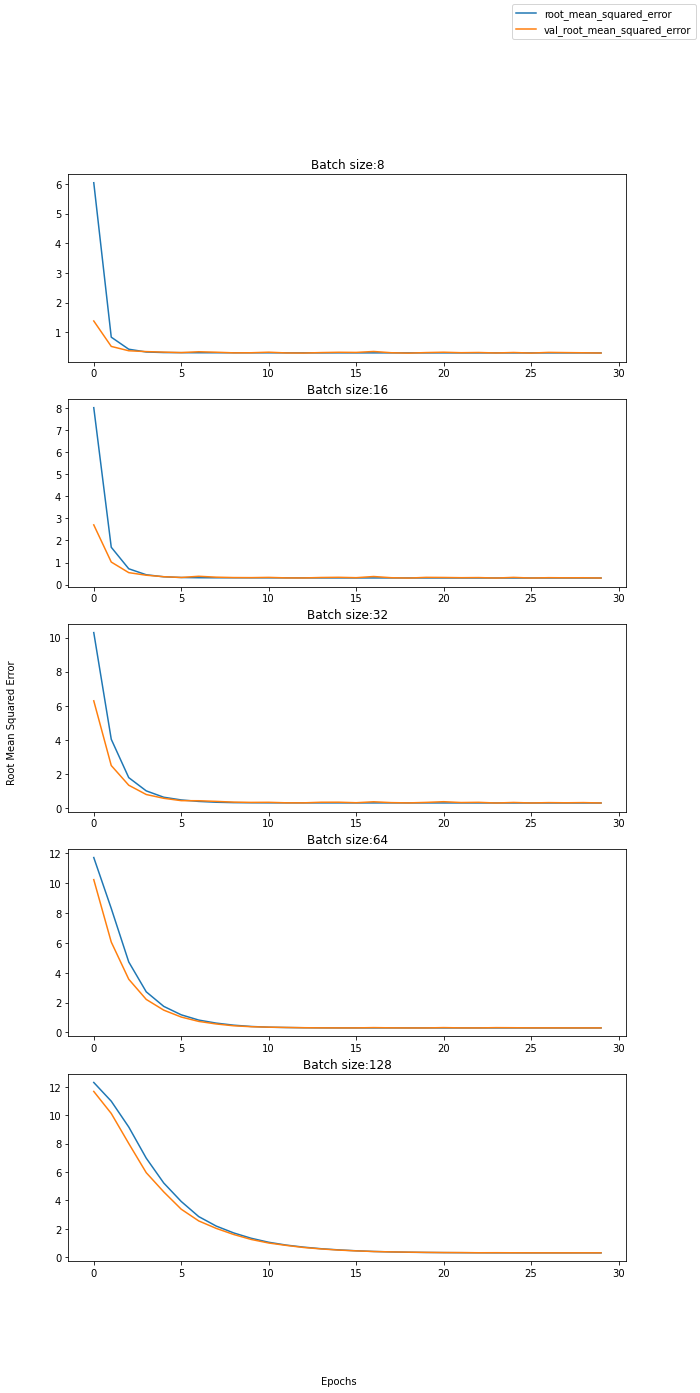

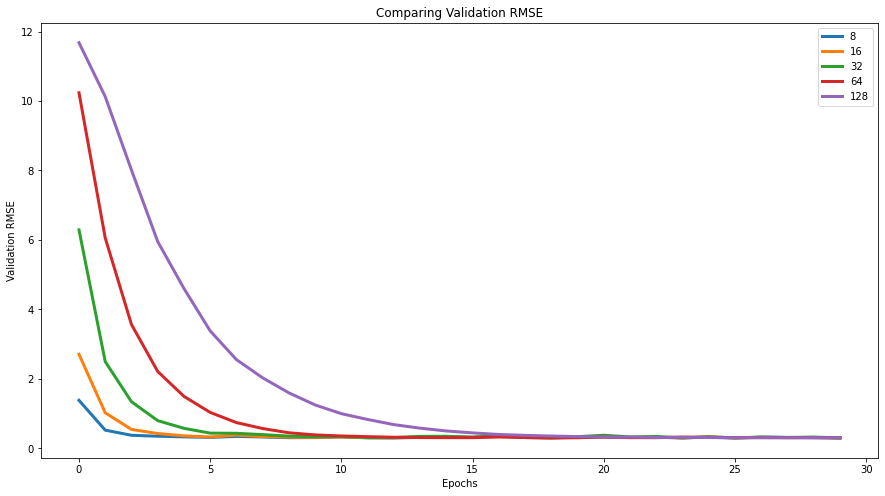

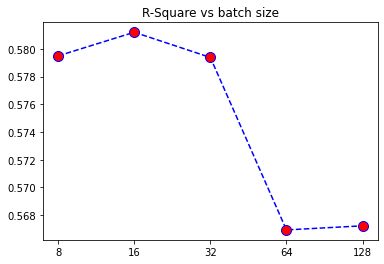

In [119]:
#Plot graphs
plotPerformance(batch_measures, "Batch size:", len(batch_measures)) #Plot training erros
plotComparison(batch_measures, "Comparing Validation RMSE")
plotTestR2(batch_test, list(batch_measures.keys()), "R-Square vs batch size") #Plot test errors

We can see that batch size of 16 gives the best performance. But had to revert back and select 8, because its performing well.

## 4.8 Epochs
Here, we train the base model with different values of epochs from 10 to 100. We would like to know what happens to model when trained with different epochs.

In [120]:
epoch_measures = {}
epoch_test = []
for i in range(10, 100, 20):
    base_config = baseModel(value={'verbose':0, 'lr':0.001, 'h_nodes':[8, 8], 'optimizer':'adam', 'activation':'relu', 'loss':'mse', 'batch':16})
    base_config['epochs'] = i
    name = "epoch_"+ str(i)
    print("Training with Number of epochs:", base_config['epochs'])
    training = initRunModel(base_config, X_train=X_train, y_train=y_train, model=name, batchNormalise=False, summary=False)
    epoch_measures[i] = training[0]
    y_pred = training[1].predict(X_test)
    r2 = metrics.r2_score(y_test, y_pred)
    epoch_test.append(r2)
    print("Evaluating Model, RMSE = ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R square Score:', r2, '\n')

Training with Number of epochs: 10
Evaluating Model, RMSE =  0.30878334954747594
R square Score: 0.5470782026364969 

Training with Number of epochs: 30
Evaluating Model, RMSE =  0.2969220464736576
R square Score: 0.5812060833237882 

Training with Number of epochs: 50
Evaluating Model, RMSE =  0.3085388076274536
R square Score: 0.5477953041796715 

Training with Number of epochs: 70
Evaluating Model, RMSE =  0.3024766944025144
R square Score: 0.5653904044728801 

Training with Number of epochs: 90
Evaluating Model, RMSE =  0.3032763749445099
R square Score: 0.5630893461504589 



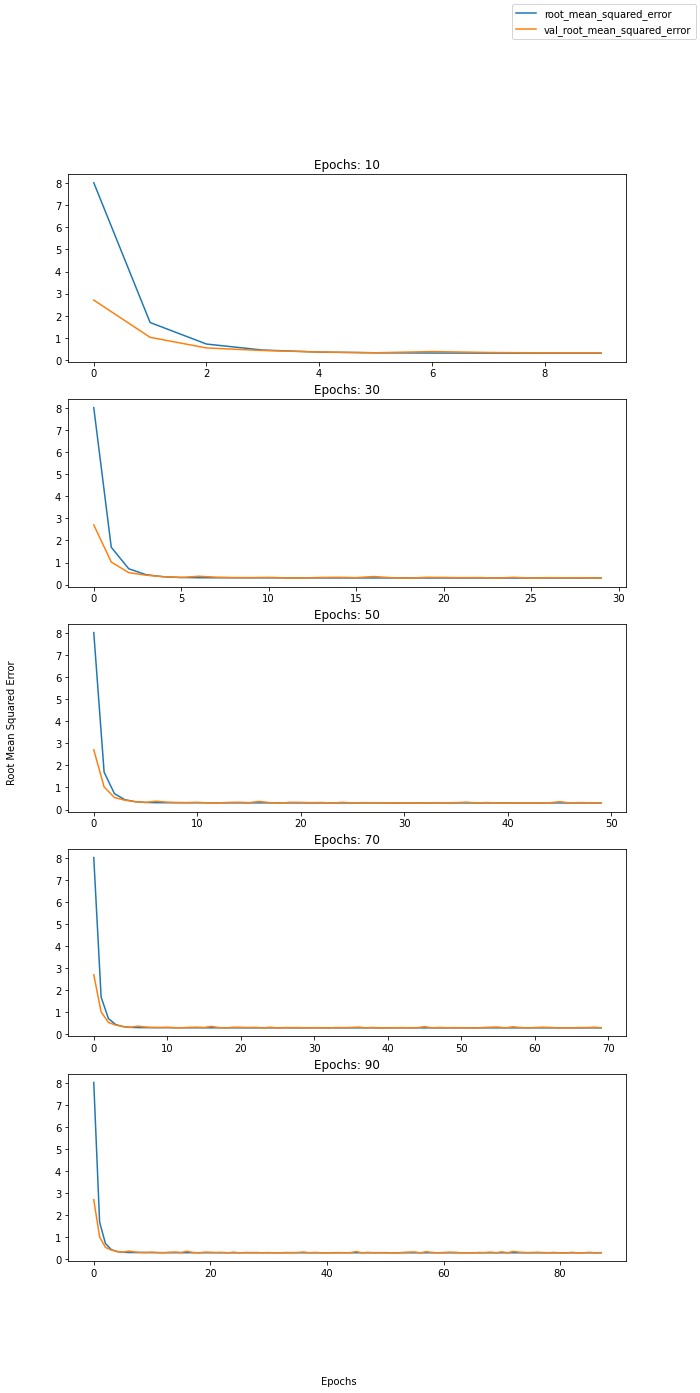

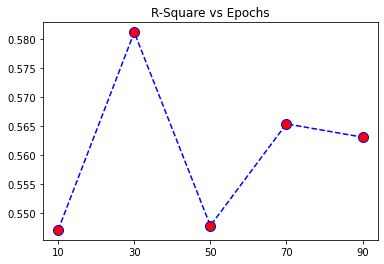

In [121]:
#Plot Graphs
plotPerformance(epoch_measures, "Epochs: ", len(epoch_measures)) #Plot train errors
# plotComparison(epoch_measures, "Comparing Validation RMSE")
plotTestR2(epoch_test, list(epoch_measures.keys()), "R-Square vs Epochs") #Plot test errors

Best score is obtained at 30 epochs, but reverted back and selected 50 epochs.

# 5.Final Model
We train the final model with the best hyperparameters obtained.

In [5]:
finalModelConfig = baseModel(value={'verbose':1, 'lr':0.001, 'h_nodes':[8, 8], 'optimizer':'adam', 'activation':'relu', 'loss':'mse', 'batch':8, 'epochs':50})

training = initRunModel(finalModelConfig, X_train=X_train, y_train=y_train, model="FinalModel", batchNormalise=False, dropOut=False, summary=True)




Model: "FinalModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_layer_0 (Dense)        (None, 8)                 136       
_________________________________________________________________
Dense_layer_1 (Dense)        (None, 8)                 72        
_________________________________________________________________
Output (Dense)               (None, 1)                 9         
Total params: 217
Trainable params: 217
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1533/1533 [==============================] - 1s 489us/step - loss: 36.8507 - root_mean_squared_error: 6.0451 - val_loss: 2.2193 - val_root_mean_squared_error: 1.3800
Epoch 2/50
1533/1533 [==============================] - 1s 433us/step - loss: 0.9458 - root_mean_squared_error: 0.8335 - val_loss: 0.4641 - val_root_mean_squared_error: 0.5216
Epoch 3/50
1533/1533 [==========

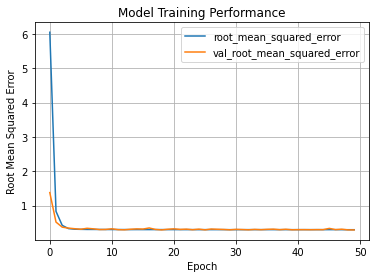

In [6]:
#Plot model performance
plotModelPerformance(training[0])

## 5.1 Predict using test data

In [7]:
#Predict using test data
y_pred = training[1].predict(X_test)
y_pred = np.array(sum(y_pred.tolist(), []))
# y_pred = list(map(np.exp, y_pred)) #Uncomment to see convert predictions to normal scale
error = y_test - y_pred

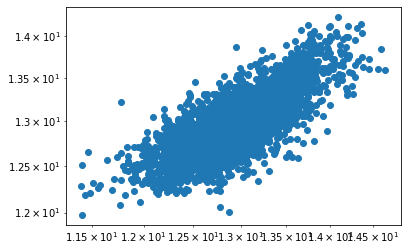

In [12]:
#Plot predictions in log scale
plt.scatter(y_test, y_pred)
plt.xscale("log")
plt.yscale("log")

In [164]:
# Evaluate Performance
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R square Score:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 0.23098503132650952
Mean Squared Error: 0.08550913309776886
Root Mean Squared Error: 0.2924194471948965
R square Score: 0.5938111686875528


The best model has a R-squared value of 59 %.
Model Hyperparameters:-

- Learning Rate:0.001
- Number of Layers: 2
- Hidden Nodes in each layer: 8
- optimizer: adam
- activation: relu
- loss: mse
- batch size: 8
- epochs:50

(array([1.000e+00, 3.000e+00, 4.300e+01, 2.340e+02, 6.950e+02, 1.233e+03,
        1.163e+03, 3.780e+02, 6.100e+01, 2.000e+01]),
 array([-1.44519119, -1.19342006, -0.94164894, -0.68987781, -0.43810668,
        -0.18633555,  0.06543557,  0.3172067 ,  0.56897783,  0.82074895,
         1.07252008]),
 <BarContainer object of 10 artists>)

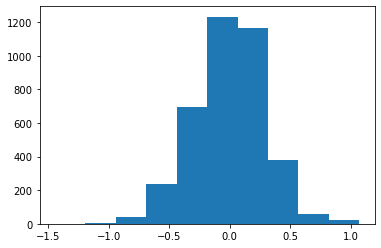

In [165]:
# Plot Errors
plt.hist(error)

Residuals are plotted in the above graph.